
# EDA — Predicción de Enfermedad Cardíaca (Cleveland UCI)


**Ejecución:** este notebook está diseñado para correr **en local (VS Code/Jupyter)** o **en Google Colab**. Descarga el dataset directamente desde Kaggle.

---





In [1]:
# ==============================================
# Kaggle: configurar token y descargar dataset (WINDOWS/LOCAL/Colab)
# ==============================================
import os, sys, zipfile, pathlib

DATA_DIR = pathlib.Path("./data"); DATA_DIR.mkdir(exist_ok=True)

def setup_kaggle_token():
    # 1)  ruta manual 
    manual_path  = pathlib.Path(r"C:\Users\Lenovo\OneDrive\Desktop\Proyecto Entrega 1\kaggle.json")
    # 2) Ruta estándar que la CLI de Kaggle siempre lee
    default_dir  = pathlib.Path.home() / ".kaggle"
    default_path = default_dir / "kaggle.json"
    default_dir.mkdir(parents=True, exist_ok=True)

    if manual_path.exists():
        default_path.write_bytes(manual_path.read_bytes())
        try:
            os.chmod(default_path, 0o600)  # en Windows no es crítico
        except Exception:
            pass
        print(f"Copiado kaggle.json a {default_path}")
    elif default_path.exists():
        print(f"Usando kaggle.json existente en {default_path}")
    else:
        # Flujo Colab (si aplica)
        try:
            from google.colab import files  # type: ignore
            print("Sube tu kaggle.json…")
            up = files.upload()
            if "kaggle.json" in up:
                default_path.write_bytes(up["kaggle.json"])
                try:
                    os.chmod(default_path, 0o600)
                except Exception:
                    pass
                print(f"kaggle.json instalado en {default_path}")
            else:
                raise FileNotFoundError("No subiste kaggle.json")
        except Exception as e:
            raise FileNotFoundError(
                "No se encontró kaggle.json. Copia tu archivo a C:\\Users\\Lenovo\\.kaggle\\kaggle.json "
                "o ajusta 'manual_path' en esta celda."
            ) from e

    # Sugerir a la CLI dónde está el config (opcional pero útil)
    os.environ["KAGGLE_CONFIG_DIR"] = str(default_dir)

def ensure_kaggle_cli():
    # Evita importar el paquete en Python (provoca autenticación inmediata).
    # Sólo aseguramos que la CLI esté instalada.
    import shutil, subprocess
    if shutil.which("kaggle") is None:
        print("Instalando kaggle CLI…")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "kaggle"])

def download_dataset():
    import subprocess
    print("Descargando dataset cherngs/heart-disease-cleveland-uci …")
    subprocess.check_call(
        ["kaggle", "datasets", "download", "-d", "cherngs/heart-disease-cleveland-uci", "-p", "./data", "--force"]
    )
    # Descomprimir y limpiar zips
    for z in DATA_DIR.glob("*.zip"):
        import zipfile
        with zipfile.ZipFile(z, "r") as zip_ref:
            zip_ref.extractall(DATA_DIR)
        z.unlink()

# Flujo
setup_kaggle_token()
ensure_kaggle_cli()
download_dataset()

print("Archivos en ./data:")
for p in DATA_DIR.glob("*"):
    print(" -", p.name)



Copiado kaggle.json a C:\Users\Lenovo\.kaggle\kaggle.json
Descargando dataset cherngs/heart-disease-cleveland-uci …
Archivos en ./data:
 - heart_cleveland_upload.csv


In [2]:
# ==============================================
# Imports y utilidades
# ==============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True

DATA_DIR = Path("./data")

# Detectar archivo CSV automáticamente
def find_heart_csv():
    candidates = list(DATA_DIR.glob("*.csv"))
    if not candidates:
        raise FileNotFoundError("No se encontró ningún CSV en ./data tras la descarga.")
    # Preferir nombres comunes
    preferred = [p for p in candidates if "heart" in p.name.lower()]
    return preferred[0] if preferred else candidates[0]

csv_path = find_heart_csv()
print("Usando CSV:", csv_path)

# Cargar el dataset
df = pd.read_csv(csv_path)
print("Dimensiones:", df.shape)

# Detectar y renombrar variable objetivo si es necesario
if "condition" in df.columns and "target" not in df.columns:
    df = df.rename(columns={"condition": "target"})
    print("Columna 'condition' renombrada a 'target' para compatibilidad con el EDA.")

elif "target" in df.columns:
    print("Columna 'target' detectada correctamente.")

else:
    print(" No se encontró columna 'target' ni 'condition'. Verifica los nombres del dataset.")

# Mostrar las primeras filas
df.head()


Usando CSV: data\heart_cleveland_upload.csv
Dimensiones: (297, 14)
Columna 'condition' renombrada a 'target' para compatibilidad con el EDA.


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0



El conjunto de datos incluye 297 registros y 14 variables. Los datos no presentan valores nulos notables. Se encuentran variables como la edad, la presión arterial, el colesterol, la frecuencia cardíaca máxima. La variable objetivo 'condition' se renombro como 'target', y se encuentra está binarizada correctamente.


## 2. Pregunta de negocio y objetivos del EDA

**Pregunta de negocio:**  
> ¿Podemos predecir la probabilidad de que un paciente adulto presente enfermedad cardíaca usando variables clínicas como edad, presión arterial, colesterol y pruebas de esfuerzo?

**Objetivos del EDA:**  
1. Comprender la calidad y distribución de las variables clínicas.  
2. Analizar relaciones entre variables y su asociación con la presencia de enfermedad (target).  
3. Formular hipótesis y hallazgos que guíen el modelado supervisado.  
4. Generar un dataset limpio y documentado para entrenamiento/validación.

---

## 3. Diccionario de datos

- `age`: edad en años.  
- `sex`: (1 = hombre, 0 = mujer).  
- `cp`: tipo de dolor en el pecho (4 categorías).  
- `trestbps`: presión arterial en reposo (mm Hg).  
- `chol`: colesterol sérico (mg/dl).  
- `fbs`: azúcar en ayunas > 120 mg/dl (1 = sí, 0 = no).  
- `restecg`: resultados ECG en reposo (valores categóricos).  
- `thalach`: frecuencia cardíaca máxima alcanzada.  
- `exang`: angina inducida por ejercicio (1 = sí, 0 = no).  
- `oldpeak`: depresión ST inducida por ejercicio respecto al reposo.  
- `slope`: pendiente del segmento ST del ejercicio máximo.  
- `ca`: número de vasos mayores coloreados por fluoroscopia (0-3).  
- `thal`: talasemia (3 = normal, 6 = defecto fijo, 7 = defecto reversible).  
- `target`: presencia de enfermedad (1 = sí, 0 = no).


In [4]:

# ==============================================
#  Calidad de datos: tipos, nulos, estadísticos
# ==============================================
print("Tipos de datos:")
print(df.dtypes)
print("\nValores nulos por columna:")
print(df.isnull().sum())

# Estadísticos básicos
display(df.describe(include='all'))

# Detección de codificaciones de nulos comunes 
for col in df.columns:
    if df[col].dtype == 'object':
        nunique = df[col].nunique()
        if "?" in df[col].unique():
            print(f"Columna '{col}' contiene '?' -> posible nulo codificado. Convirtiendo a NaN.")
            df[col] = df[col].replace("?", np.nan)

print("\nValores nulos después de limpieza :")
print(df.isnull().sum())


Tipos de datos:
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

Valores nulos por columna:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,2.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,0.602694,0.676768,0.835017,0.461279
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,0.956690,0.499340
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,2.000000,1.000000



Valores nulos después de limpieza :
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


La información es bastante clara: no hay valores nulos en ninguna columna y los datos son todos numéricos (principalmente enteros, pero oldpeak es decimal). Esto permite un análisis estadístico sin imputaciones. La edad media de los pacientes es de aproximadamente 54 años y la mayoría son hombres (≈68%). Estas variables tienen distribuciones  coherentes: presión arterial (94–200 mm Hg), colesterol (126–564 mg/dL) y frecuencia cardíaca máxima (71–202 bpm).

Distribución de target (0=sin enfermedad, 1=con enfermedad):
target
0    160
1    137
Name: count, dtype: int64


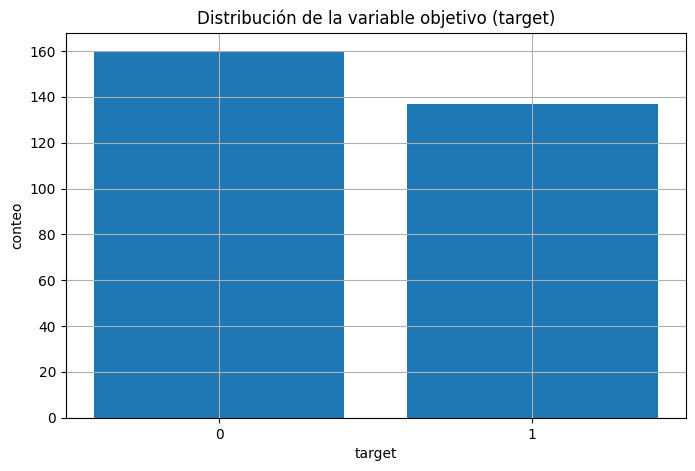

Índice de balance de clases (min/max): 0.86


In [6]:

# ==============================================
# Distribución de la variable objetivo (target)
# ==============================================
if "target" not in df.columns:
    raise KeyError("El dataset no contiene la columna 'target'. Verifica el CSV cargado.")

counts = df["target"].value_counts().sort_index()
print("Distribución de target (0=sin enfermedad, 1=con enfermedad):")
print(counts)

# Gráfico de barras (matplotlib, sin estilos ni colores específicos)
fig = plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Distribución de la variable objetivo (target)")
plt.xlabel("target")
plt.ylabel("conteo")
plt.show()

imbalance = counts.min() / counts.max()
print(f"Índice de balance de clases (min/max): {imbalance:.2f}")


Esta distribución muestra que el conjunto de datos está bien equilibrado: 160 casos sin enfermedad, 137 con enfermedad; esto produce un índice de equilibrio de 0.86. Esto indica que actualmente no hay una clase dominante en el conjunto de datos y no se deben usar métodos de reequilibrio por el modelo

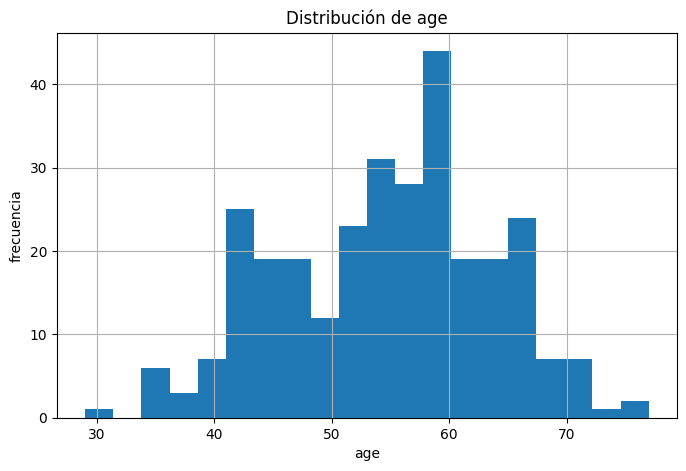

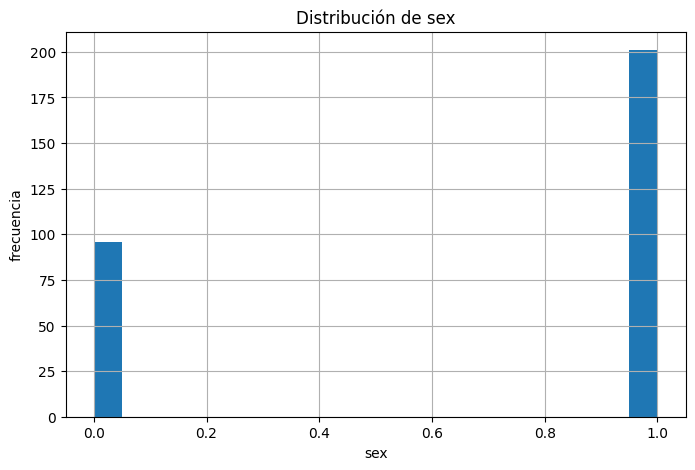

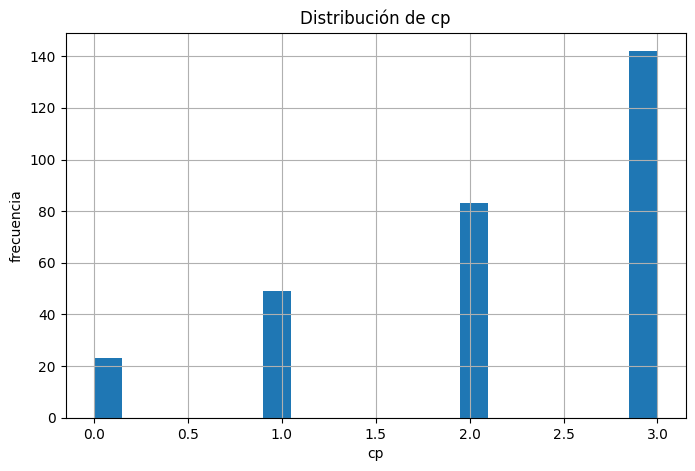

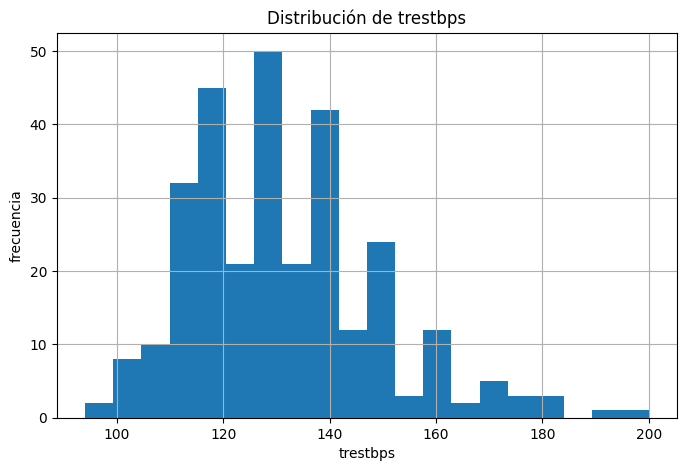

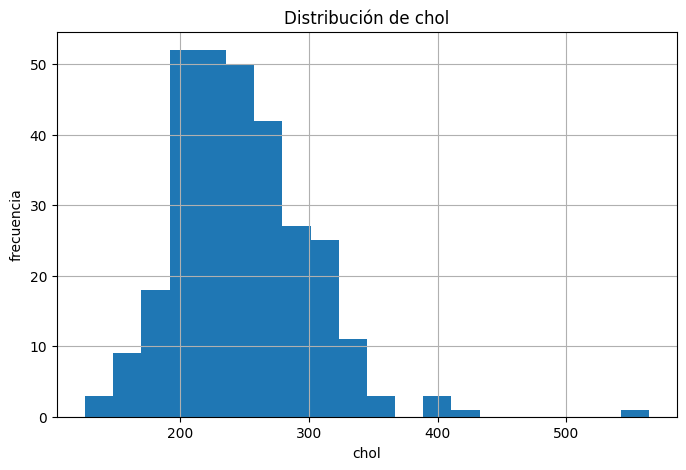

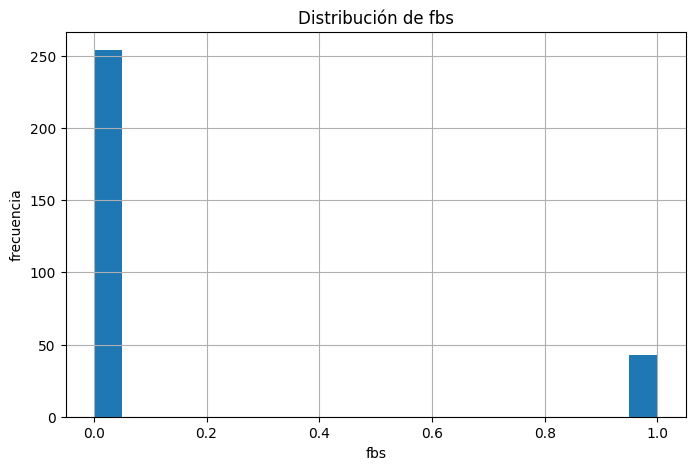

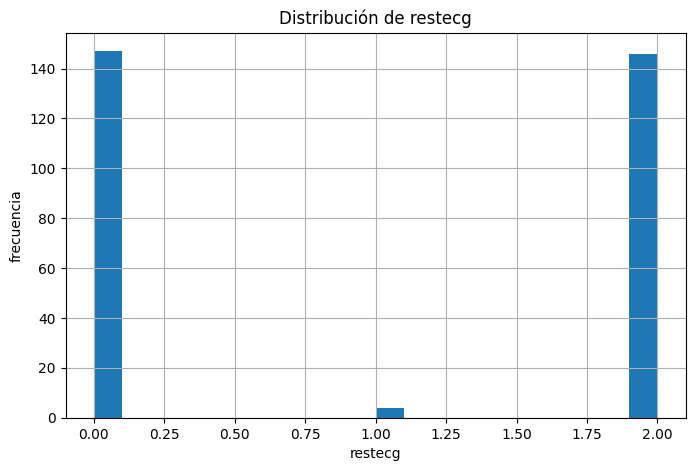

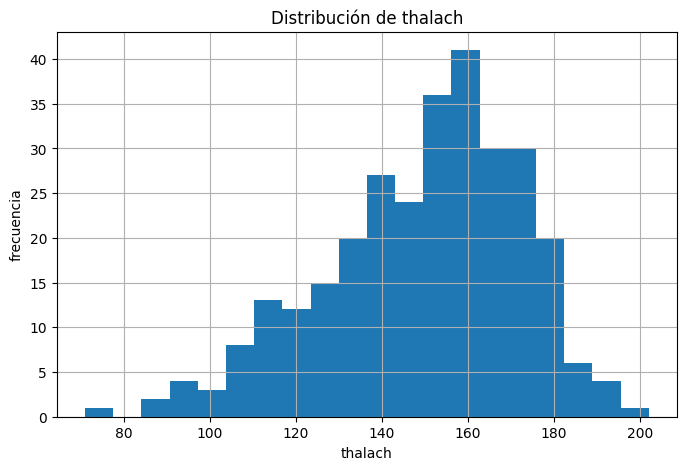

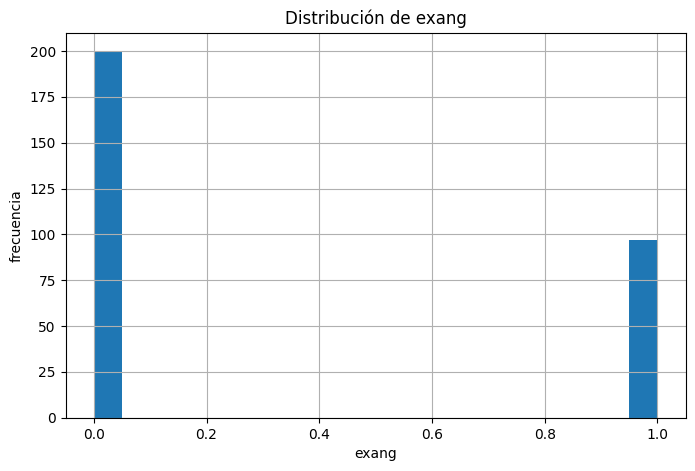

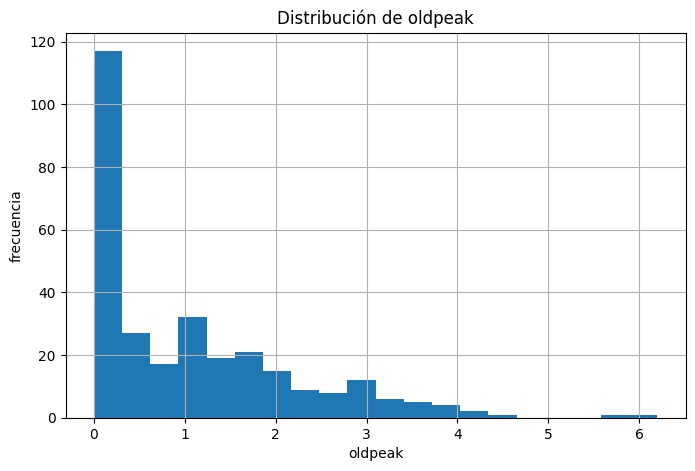

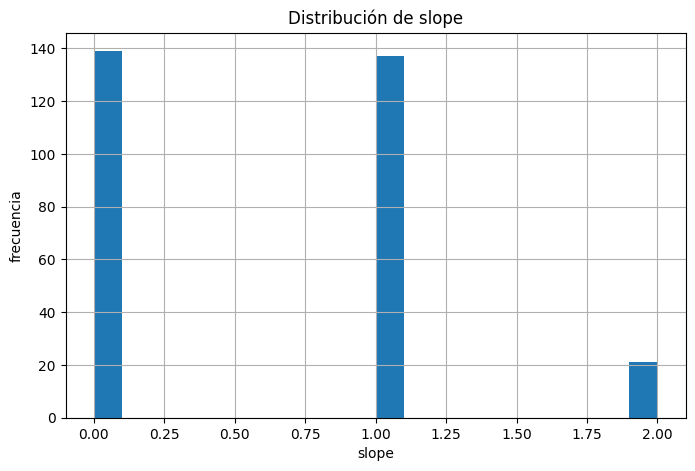

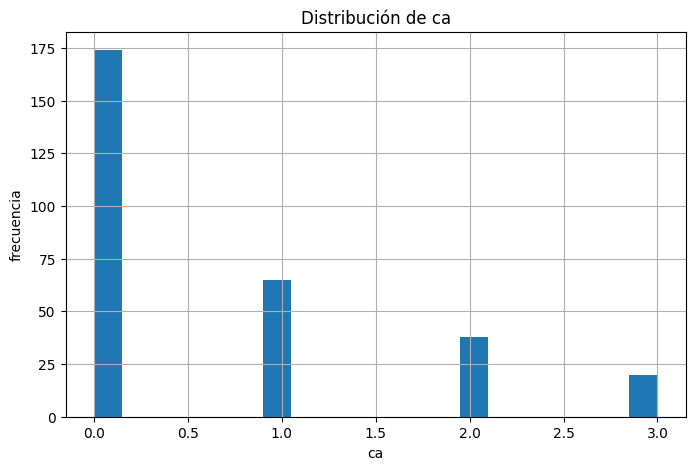

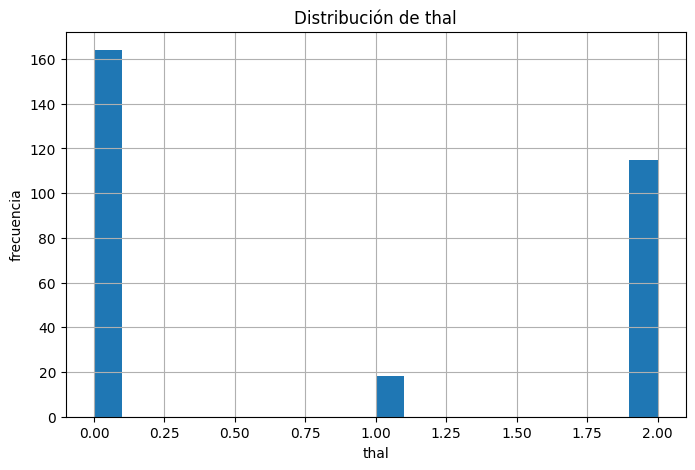

In [8]:

# ==============================================
# Análisis univariado (numéricas)
# ==============================================
numeric_cols = [c for c in df.columns if df[c].dtype.kind in "biufc" and c != "target"]

for col in numeric_cols:
    fig = plt.figure()
    plt.hist(df[col].dropna(), bins=20)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("frecuencia")
    plt.show()


Las variables muestran bien las distribuciones numéricas y categóricas. La mayor frecuencia se encuentra en la edad, concentrada dentro de la categoría de 50-60 años, lo que sugiere que la mayoría de los registros parecen caer en esa categoría. En sexo, el valor 1 aparece en aproximadamente dos tercios de los casos, indicando cierta asimetría. La columna cp tiene valores de 0 a 3 y el nivel 3 la domina, mostrando un número bastante alto de valores en una sola categoría. Como podemos ver, las variables continuas como trestbps y chol tienen una forma de clase normal, centrada alrededor de 130 y 245, alrededor de los valores centrales hay algunos valores más allá de este rango sin signos de datos fuera de rango. Thalach está en proximidad a 150, pero hay una pequeña dispersión y no se muestra sesgo. En contraste, oldpeak tiene una fuerte asimetría a la derecha: la mayoría de los valores están cerca de cero, con pocas instancias con un valor relativamente alto. En las variables categóricas binarias (fbs, restecg, exang, slope, ca, thal), se observan altas concentraciones en una o dos clases. Fbs está casi completamente dominado por 0, mientras que restecg y exang contienen dos grupos distintos. En slope prevalecen 0 y 1, y en ca emerge una disminución progresiva en la frecuencia a medida que el valor aumenta. Y thal también recibe más peso en las categorías 0 y 2.

In [9]:

# ==============================================
# Comparativas por clase (target)
# ==============================================
group_stats = df.groupby("target")[numeric_cols].agg(["mean","median","std","min","max"])
group_stats


age                                sex                           \
             mean median       std min max      mean median       std min max   
target                                                                          
0       52.643750   52.0  9.551151  29  76  0.556250    1.0  0.498386   0   1   
1       56.759124   58.0  7.899670  35  77  0.817518    1.0  0.387658   0   1   

        ...        ca                               thal                       \
        ...      mean median       std min max      mean median       std min   
target  ...                                                                     
0       ...  0.275000    0.0  0.633945   0   3  0.375000    0.0  0.758599   0   
1       ...  1.145985    1.0  1.018506   0   3  1.372263    2.0  0.882904   0   

            
       max  
target      
0        2  
1        2  

[2 rows x 65 columns]

En cuanto a las variables segmentándolas por valor objetivo (0 = ausencia de enfermedad y 1 = presencia de enfermedad), las diferencias numéricas entre ambos grupos se hacen evidentes si se desglosan. Una edad media de 56.8 años; 52.6 años para objetivo = 0 para los registros. Por lo tanto, los valores de edad son algo más altos en el grupo con enfermedad. La media en la variable de sexo está entre 0.55 y 0.82 (es decir, mayor prevalencia del valor 1 (masculino) en una población con enfermedad). La mayoría de las variables demuestran desviaciones estándar estables, lo que indica una dispersión controlada y sin grandes valores atípicos. En una comparación entre ca (número de vasos coloreados) y thal (resultado de la prueba de perfusión), encontramos un aumento marcado en la media al pasar de objetivo = 0 a objetivo = 1. La media aumenta de 0.27 a 1.14 en ca, y de 0.37 a 1.37 en thal. Eso significa que los registros para el grupo con enfermedad se concentran en las categorías más altas en estas variables. Así que el análisis estadístico general indica que la edad, el sexo, ca y thal muestran las mayores diferencias entre estos grupos y, por lo tanto, la información proporcionada es relevante para distinguir casos.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24392\977054215.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=["0","1"])


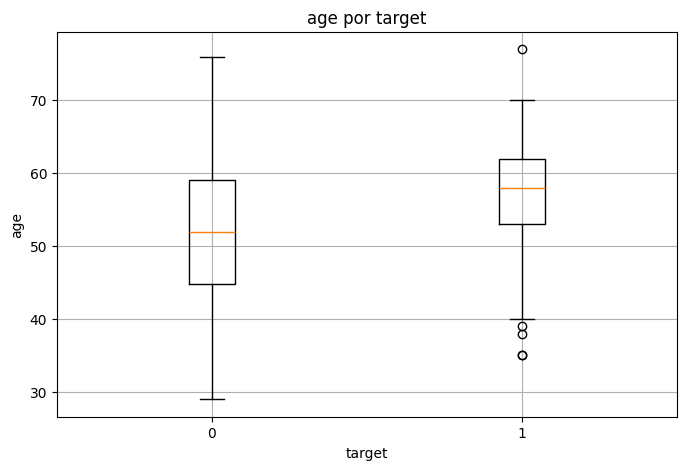

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24392\977054215.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=["0","1"])


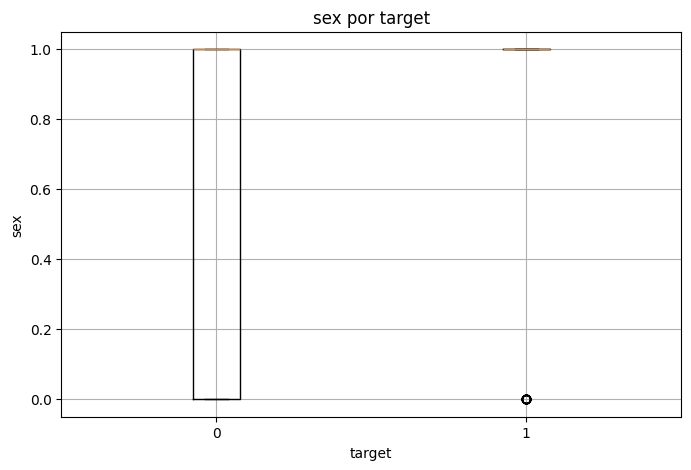

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24392\977054215.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=["0","1"])


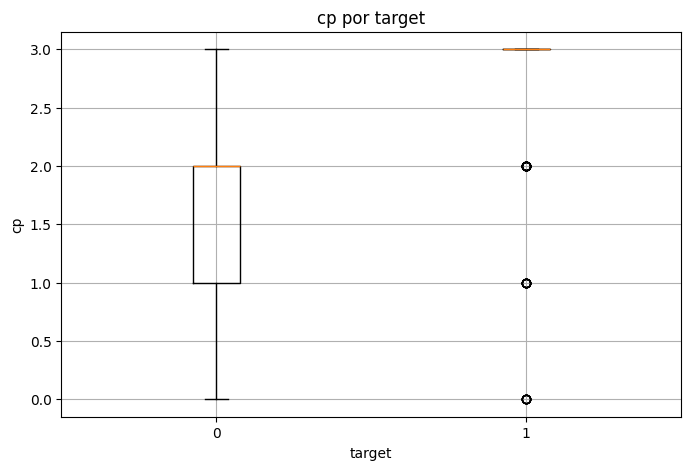

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24392\977054215.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=["0","1"])


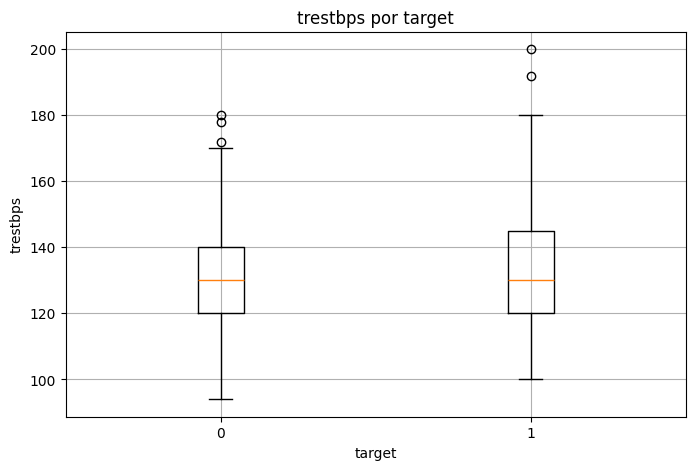

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24392\977054215.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=["0","1"])


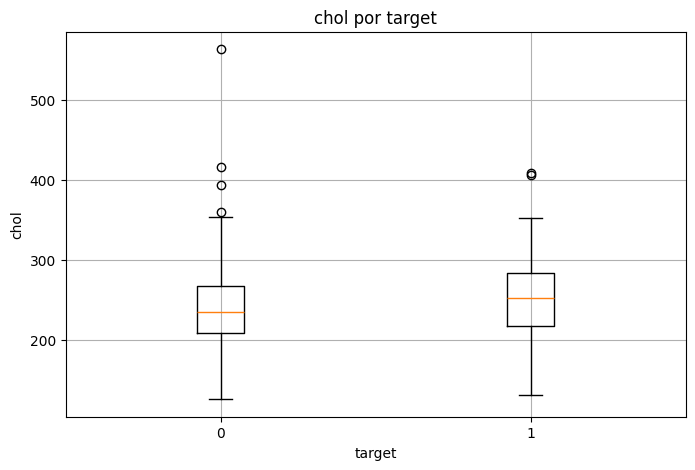

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24392\977054215.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=["0","1"])


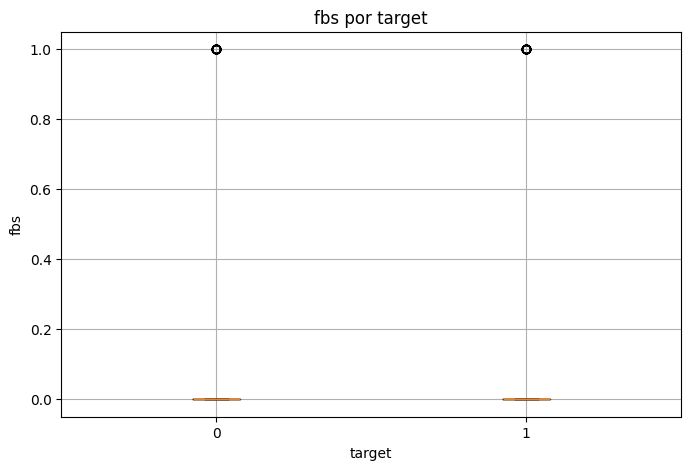

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24392\977054215.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=["0","1"])


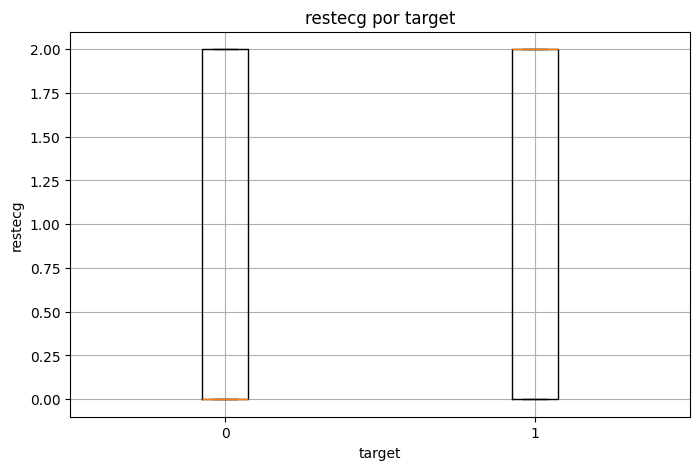

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24392\977054215.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=["0","1"])


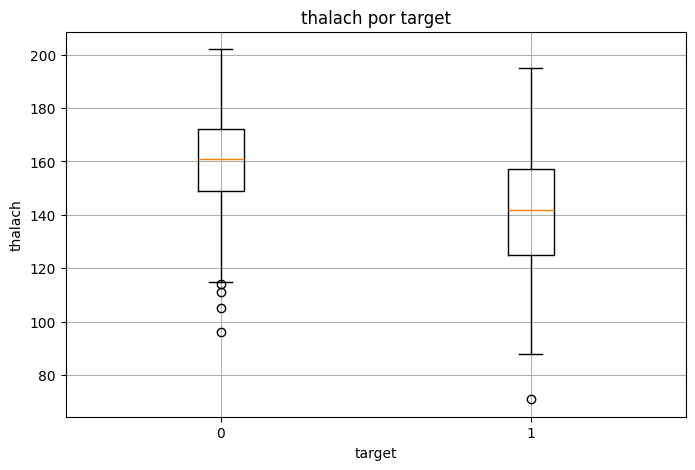

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24392\977054215.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=["0","1"])


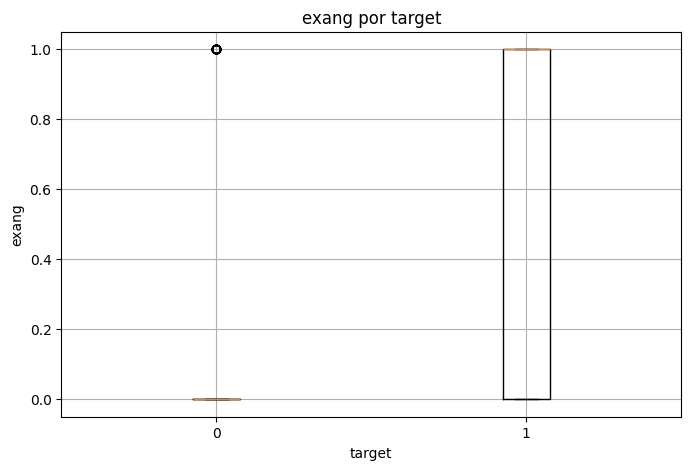

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24392\977054215.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=["0","1"])


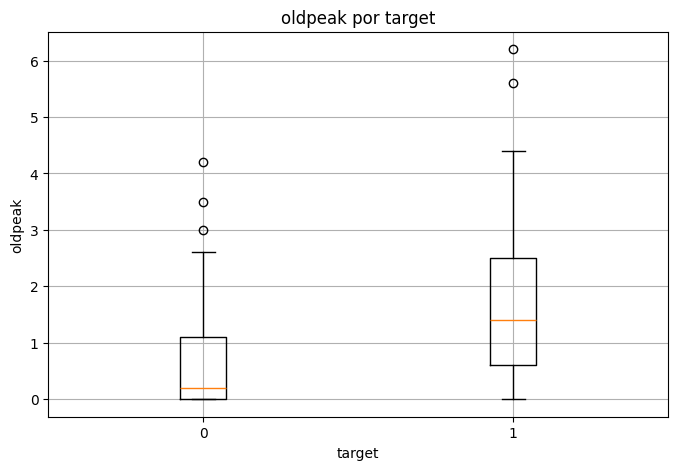

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24392\977054215.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=["0","1"])


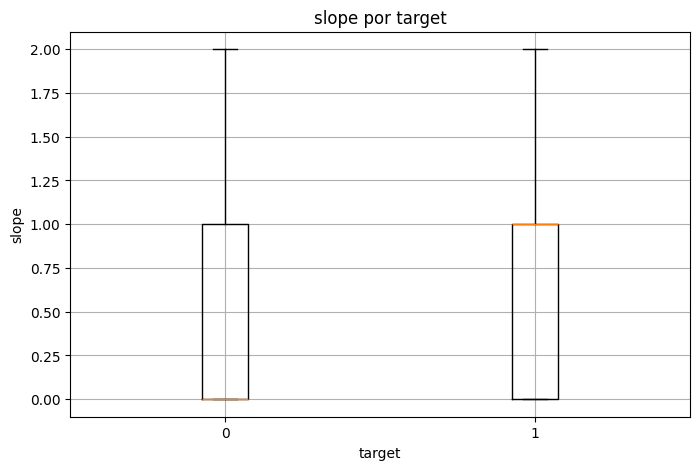

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24392\977054215.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=["0","1"])


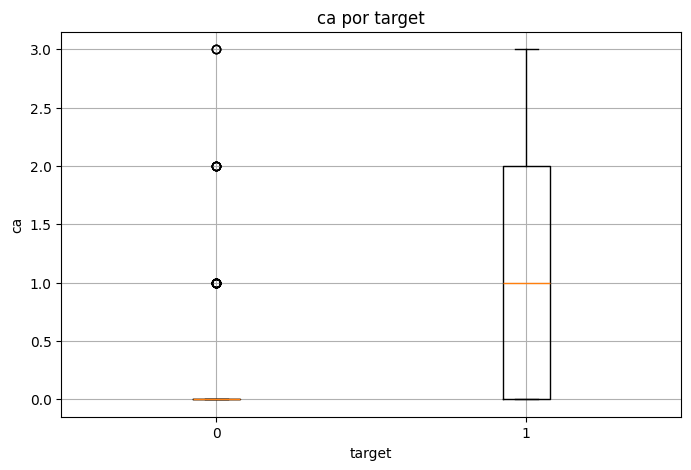

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24392\977054215.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=["0","1"])


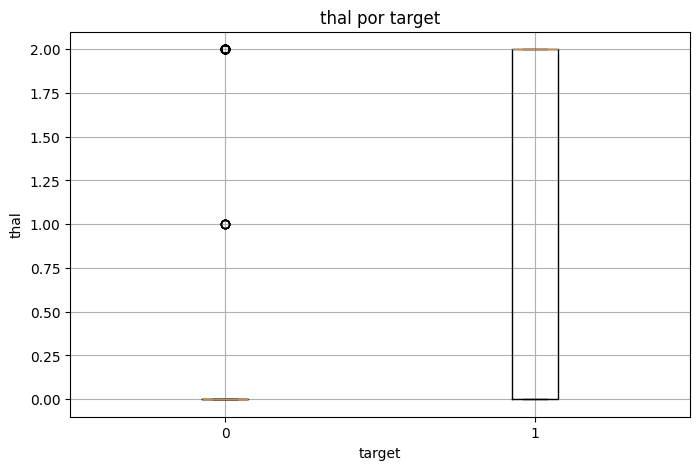

In [10]:

# Boxplots por variable numérica segregada por target
for col in numeric_cols:
    fig = plt.figure()
    # Preparar datos
    x0 = df.loc[df["target"]==0, col].dropna()
    x1 = df.loc[df["target"]==1, col].dropna()
    plt.boxplot([x0, x1], labels=["0","1"])
    plt.title(f"{col} por target")
    plt.xlabel("target")
    plt.ylabel(col)
    plt.show()


Nuestro análisis conjunto de las variables muestra discrepancias numéricas y de dispersión estadísticamente significativas entre los dos:

Edad (age): los casos con enfermedad tienen una mediana más alta (~58 años) que los registros sin enfermedad (~52 años), exhibiendo menor variabilidad.

Sexo (sex): el grupo de pacientes (personas con enfermedad) está concentrado en el grupo 1 (masculino), mientras que el grupo sin enfermedad está más equilibrado.

Tipo de dolor torácico (cp): hay más categorías sin enfermedad, mientras que aquellos con enfermedad se agrupan en el valor superior.

Presión arterial en reposo (trestbps): mismas medianas para los grupos (~130), aunque el grupo con enfermedad tiene un rango algo más amplio.

Colesterol (chol): distribución similar para ambos grupos; con medianas de casi 240 y pocos valores altos para ambos grupos.

Azúcar en sangre (fbs): la mayoría de los registros presentan el valor 0, y no se observan diferencias entre los grupos.

Resultado del electrocardiograma (restecg): los extremos (0 y 2) dominan tanto los registros con como sin enfermedad.

Frecuencia cardíaca máxima (thalach): los registros sin enfermedad tienen valores más altos (mediana casi 160) en comparación con aquellos con enfermedad (mediana ~140), indicando una disminución de esta variable por el segundo grupo.

Ejercicio inducido (exang): 0 es la mayoría de los valores en casos sin enfermedad, y 1 es más frecuente en casos con enfermedad.

Depresión del ST (oldpeak): las diferencias entre grupos son bastante evidentes; los registros con enfermedad alcanzan valores más altos y están más dispersos, mientras que los casos sin enfermedad están cerca de cero.

Pendiente del segmento ST (slope): el rango es el mismo en cada grupo, pero con registros de enfermedad estamos más agrupados en valores intermedios, mostrando una ligera diferencia en la mediana.

Número de vasos coloreados (ca): esta variable tiene una clara separación, donde el grupo sin enfermedad es el que está en valores bajos (0), y los casos con la enfermedad están en el nivel alto y hay amplias desviaciones (mediana ~1).

Prueba de perfusión (thal): el grupo no enfermo está concentrado en las categorías bajas, mientras que los registros con enfermedad muestran un porcentaje más alto en categorías altas (mediana ~2).

target      1.000000
thal        0.520516
ca          0.463189
oldpeak     0.424052
exang       0.421355
cp          0.408945
slope       0.333049
sex         0.278467
age         0.227075
restecg     0.166343
trestbps    0.153490
chol        0.080285
fbs         0.003167
thalach    -0.423817
Name: target, dtype: float64


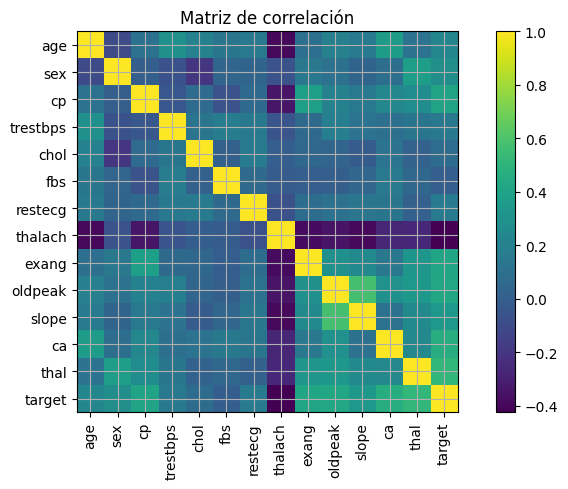

In [11]:

# ==============================================
#  Correlaciones (numéricas)
# ==============================================
corr = df[numeric_cols + ["target"]].corr()
print(corr["target"].sort_values(ascending=False))

fig = plt.figure()
plt.imshow(corr, interpolation='nearest')
plt.title("Matriz de correlación")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
plt.tight_layout()
plt.show()


Las variables independientes con la correlación positiva más alta con el objetivo son:

La prueba de perfusión (thal) tiene una alta correlación (0.52), lo que indica que el tipo de resultado de la prueba de perfusión está estrechamente relacionado con la enfermedad. El número de vasos coloreados (ca) con un valor de correlación de 0.46 indica una correlación positiva observada para el mayor número de vasos anormales de la categoría de enfermedad. La depresión del ST (oldpeak): correlación 0.42; cuanto mayor es la depresión, más se encuentra en el grupo con enfermedad. Inducido por el ejercicio (exang): correlación de 0.42: la enfermedad aparece más comúnmente en pacientes en la etapa de esfuerzo. Tipo de dolor en el pecho (cp): correlación 0.41, lo que respalda que la naturaleza del dolor es importante para la clasificación del diagnóstico. Pendiente del segmento ST (slope): correlación moderada (0.33), proporcionando así más información sobre la acción cardíaca durante el esfuerzo. Sexo (sex) y Edad (age): correlaciones positivas más pequeñas (0.27 y 0.23), indicando que la enfermedad es más común en hombres y en edades más avanzadas.

Por otro lado, solo aparece la correlación negativa significativa en:

Frecuencia cardíaca máxima (thalach): con -0.42, indicando que los pacientes que tienen una frecuencia cardíaca más baja alcanzada durante el ejercicio tienen más probabilidades de caer en la categoría de enfermedad.

Para otros, como el colesterol (chol), la presión arterial en reposo (trestbps), el azúcar en sangre (fbs) y el resultado del ECG (restecg), las correlaciones son extremadamente bajas (<0.2), lo que sugiere poca o indirecta influencia en la clasificación final.

In [12]:

# ==============================================
# Tests simples de diferencia entre clases
# ==============================================
try:
    from scipy.stats import ttest_ind, chi2_contingency
except Exception:
    import sys
    print("Instalando SciPy para pruebas estadísticas...")
    os.system(sys.executable + " -m pip install --quiet scipy")
    from scipy.stats import ttest_ind, chi2_contingency

results_tests = {}
y0 = df["target"]==0
y1 = df["target"]==1

for col in numeric_cols:
    a = df.loc[y0, col].dropna()
    b = df.loc[y1, col].dropna()
    if len(a)>2 and len(b)>2:
        stat, p = ttest_ind(a, b, equal_var=False)
        results_tests[col] = {"t_stat": stat, "p_value": p}

print("Resultados t-test (target=0 vs target=1):")
for k,v in sorted(results_tests.items(), key=lambda x: x[1]["p_value"]):
    print(f"{k:>12s} -> p={v['p_value']:.3e} | t={v['t_stat']:.3f}")


Resultados t-test (target=0 vs target=1):
        thal -> p=2.338e-21 | t=-10.349
          ca -> p=9.252e-16 | t=-8.674
     thalach -> p=6.108e-14 | t=7.929
          cp -> p=1.376e-13 | t=-7.763
       exang -> p=2.267e-13 | t=-7.773
     oldpeak -> p=3.429e-13 | t=-7.756
       slope -> p=3.532e-09 | t=-6.091
         sex -> p=6.872e-07 | t=-5.076
         age -> p=6.204e-05 | t=-4.064
     restecg -> p=4.020e-03 | t=-2.900
    trestbps -> p=8.808e-03 | t=-2.639
        chol -> p=1.650e-01 | t=-1.392
         fbs -> p=9.567e-01 | t=-0.054


Los factores que muestran las mayores diferencias entre grupos en términos de evidencia estadística. Prueba de perfusión (thal): baja con estadístico t negativo (-10.35) y valor p (2.3e-21) (confirma una marcada diferencia entre grupos). Número de vasos coloreados (ca): también significativo (p ≈ 9e-16), correlaciona con una media más alta en pacientes con la enfermedad. Frecuencia cardíaca máxima (thalach): p ≈ 6e-14, con t positivo (7.93), es decir, el grupo sin enfermedad obtiene una frecuencia media más alta. Tipo de dolor en el pecho (cp), inducido por el ejercicio (exang), depresión del ST (oldpeak): todos con p < 1e-12, proporcionan evidencia de una diferencia sustancial en el comportamiento entre grupos. Pendiente del segmento ST (slope), Sexo (sex) y Edad (age): indican diferencias relevantes, aunque menores, todas con p < 1e-4. Restecg y trestbps son moderados (p < 0.01), mientras que el colesterol (chol) y el azúcar en sangre (fbs) no producen diferencias significativas (p > 0.05), indicando que su efecto discriminativo sobre la presencia de la enfermedad es insignificante.

Varianza explicada por PCA (2 comp.): [0.23559601 0.12332151]


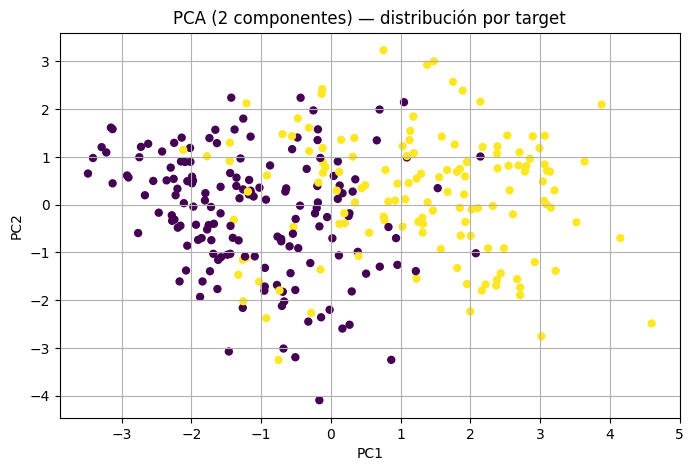

In [13]:

# ==============================================
# Visualización con PCA (2 componentes)
# ==============================================
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df.drop(columns=["target"])
y = df["target"].values

# Solo numéricas
X_num = X.select_dtypes(include=[np.number]).fillna(0.0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Varianza explicada por PCA (2 comp.):", pca.explained_variance_ratio_)

fig = plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=25)  # sin elegir colores específicos
plt.title("PCA (2 componentes) — distribución por target")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


El Análisis de Componentes Principales (PCA) reduce la dimensionalidad del conjunto de datos proyectando la información en dos componentes principales (PC1 y PC2), que juntos explican aproximadamente el 35.9% de la varianza total del conjunto de datos (PC1 = 23.6%, PC2 = 12.3%). En la visualización, se observa una separación parcial entre los grupos objetivo. Los registros con enfermedad (objetivo = 1) tienden a concentrarse en valores positivos del primer componente, mientras que los casos sin enfermedad (objetivo = 0) se agrupan más hacia los valores negativos. Esto sugiere que una combinación lineal de variables —principalmente aquellas con mayores cargas en thal, ca, oldpeak, exang y cp— ayuda a distinguir ambos grupos. Sin embargo, la superposición visible refleja que las diferencias no son completamente lineales, por lo que es probable que los modelos capaces de capturar relaciones no lineales logren un mejor rendimiento predictivo.

In [14]:

# ==============================================
# Exportación de dataset procesado (para DVC)
# ==============================================
from datetime import datetime
PROCESSED_DIR = Path("./data")
PROCESSED_DIR.mkdir(exist_ok=True)
out_name = f"heart_processed_{datetime.now().strftime('%Y%m%d')}.csv"
out_path = PROCESSED_DIR / out_name
df.to_csv(out_path, index=False)
print("Guardado:", out_path)


Guardado: data\heart_processed_20251026.csv



---

### Notas de reproducibilidad
- Este notebook evita rutas absolutas y usa `./data` como directorio relativo.
- La descarga se realiza con la **API de Kaggle**; en Colab se solicita `kaggle.json` si no está configurado.
- Las visualizaciones usan únicamente **matplotlib** para mantener compatibilidad amplia.
- El archivo exportado `heart_processed_YYYYMMDD.csv` queda listo para controlarse con **DVC** en la siguiente fase.
